In [1]:
### Python Notebook to Test Openquake and Pygmm
# Daniel Trugman, 2025


In [ ]:
### Imports

# base
import pandas as pd
import numpy as np
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("darkgrid")

# openquake - generic
# - https://docs.openquake.org/oq-engine/3.5/baselib.html#installation
#  - worked ok as !pip install openquake.engine in python 3.10 environment...
#    - but needed to add fiona afterward with mamba
# - for documentation see this:
# - https://docs.openquake.org/oq-engine/3.5/openquake.hazardlib.html
from openquake.hazardlib.contexts import RuptureContext
from openquake.hazardlib.contexts import DistancesContext
from openquake.hazardlib.contexts import SitesContext
from openquake.hazardlib import imt, const

# active crustal models
from openquake.hazardlib.gsim.abrahamson_2014 import AbrahamsonEtAl2014
from openquake.hazardlib.gsim.boore_2014 import BooreEtAl2014
from openquake.hazardlib.gsim.campbell_bozorgnia_2014 import CampbellBozorgnia2014
from openquake.hazardlib.gsim.chiou_youngs_2014 import ChiouYoungs2014


In [2]:
### Setup for Calculations

## Define Rupture Context
rctx = RuptureContext()
rctx.mag = 5.7
rctx.rake = -19
rctx.dip = 80
rctx.ztor = 0.1 #guessing
rctx.width = 10 # guessing
rctx.hypo_depth = 9.3 

## Define Distance Context (assume fault-perpendicular sites)
dctx = DistancesContext()
rjbs = np.linspace(0.0, 320.0, 321) # rjb values in km
rrups = np.sqrt(rjbs**2 + rctx.ztor**2) # calculated rupture distance for a vertical fault
npts = rrups.size # number of distance points
dctx.rrup = rrups # Closest distance to rupture surface
dctx.rjb = rjbs # Distance to rupture’s surface projection
dctx.rx = np.zeros(npts) # Perpendicular distance to rupture top edge projection
dctx.ry0 = np.zeros(npts) # Horizontal distance off the end of the rupture measured parallel to strike 
                         #  (essentially, how far a location is "along the fault" from the rupture termination point)


## Site context - seems to now need to be from a "site collection", which seems to be a pandas dataframe.
#    value to predict - if you're doing it in array form (many records for a single earthquake), then make these arrays.
sitecol_dict = {'sids': np.arange(1, npts + 1), # site id
                'vs30': 760.0 + np.zeros(npts, dtype=float), # Vs30 value in m/s
                'vs30measured': np.zeros(npts, dtype=bool), # true or false, not sure how this is used
                'z1pt0': 50.0 + np.zeros(npts, dtype=float), # depth in m (not km) to 1.0 km/s horizon
                'z2pt5': np.nan + np.zeros(npts, dtype=float), # depth in km (not m) to 2.5 km/s horizon
                }
sitecollection = pd.DataFrame(sitecol_dict)
sctx = SitesContext(sitecol=sitecollection)   

In [3]:
### Calculate Ground Motions

# define metrics
#IMT = imt.PGA()
IMT = imt.PGV()
#IMT = imt.SA(period=0.1)
uncertaintytype = const.StdDev.TOTAL

# instantiate GMMs
ASK14 = AbrahamsonEtAl2014()
BSSA14 = BooreEtAl2014()
CB14 = CampbellBozorgnia2014()
CY14 = ChiouYoungs2014()

# calculate ln ground motions for each
ln_median_ask14, ln_sd_ask14 = ASK14.get_mean_and_stddevs(sctx, rctx, dctx, IMT, [uncertaintytype])
ln_median_bssa14, ln_sd_bssa14 = BSSA14.get_mean_and_stddevs(sctx, rctx, dctx, IMT, [uncertaintytype])
ln_median_cb14, ln_sd_cb14 = CB14.get_mean_and_stddevs(sctx, rctx, dctx, IMT, [uncertaintytype])
ln_median_cy14, ln_sd_cy14 = CY14.get_mean_and_stddevs(sctx, rctx, dctx, IMT, [uncertaintytype])

# average across all four for active crustal values
ln_median_ac14 = 0.25 * (ln_median_ask14 + ln_median_bssa14 + ln_median_cb14 + ln_median_cy14)
ln_sd_ac14 = 0.25 * (ln_sd_ask14[0] + ln_sd_bssa14[0] + ln_sd_cb14[0] + ln_sd_cy14[0]) # sds are in a list of length 1


In [4]:
### Find Observed Data

df = pd.read_csv('nn00888580_default_metrics_rotd(percentile=50.0).csv')
OBSdrup = df['RuptureDistance']
OBSpga = df['PGA']
OBSpgv = df['PGV']

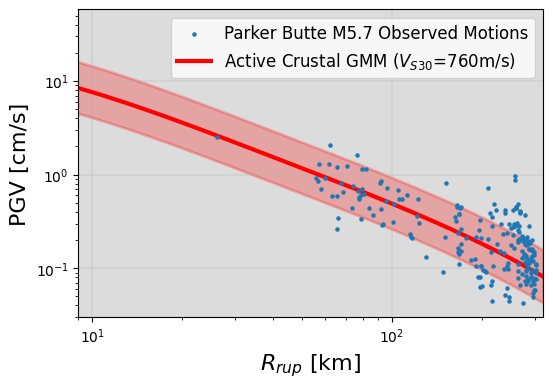

In [9]:
### Plot Model Results

# figure setup
fig, axi = plt.subplots(figsize=(6,4))
axi.set_facecolor("gainsboro")

# plot GMPE
ly1 = ln_median_ac14 - ln_sd_ac14
ly2 = ln_median_ac14 + ln_sd_ac14
axi.fill_between(x=rrups,y1=np.exp(ly1),y2=np.exp(ly2),color="r",alpha=0.25,lw=2)
plt.scatter(OBSdrup, OBSpgv, s=5, label="Parker Butte M5.7 Observed Motions", zorder=100)
axi.loglog(rrups,np.exp(ln_median_ac14),"-r",lw=3,label="Active Crustal GMM ($V_{S30}$=760m/s)")

# formatting
axi.set_xlabel("$R_{rup}$ [km]",fontsize=16)
axi.set_ylabel("PGV [cm/s]",fontsize=16)
axi.grid(lw=0.3)
axi.legend(loc="upper right",fontsize=12)
axi.set_xlim(9,320)



# show results
plt.show()

### To Do

- basin term and vs30 defaults
- optimize rupture context
- optimize distance metrics?


